# Required modules
- PyYAML
- pyorient

In [7]:
from appconfig import AppConfig, DataFileContainer
from stockdatabase import StockDatabase
from statistics import TimeRange
import statistics as st
import constants as c
import pandas as pd
import os
import matplotlib.pyplot as plt
import operator
import json

# Load information from config files

In [8]:
config = AppConfig("config/config.yml")
data_file_list = DataFileContainer("config/files.yml")

# Setup database (connect and create table and primary key fields)

In [9]:
database = StockDatabase(config.database_user, config.database_password, config.database_name,
                         config.database_host, config.database_port, config.table_index_values_name)
database.connect()
database.recreate_tables()

# Insert all index values from csv files

In [10]:
def batch_insert_index_values_from_files(database, index_file_folder_path, file_list):
    print("-- Inserting index values")
    current_index = 1
    for file in file_list:
        path = os.path.join(index_file_folder_path, file["file_name"])
        df = pd.read_csv(path)
        print("Inserting '" + file["file_name"] + "' (" + str(current_index) +
              " of " + str(len(file_list)) + ") (" + str(df.shape[0]) + " rows) ...")
        current_index += 1
        database.insert_index_values(df, file["isin"], file["region"])
    print("-- Done!")

batch_insert_index_values_from_files(database, config.data_file_folder, data_file_list.index_value_files)

-- Inserting index values
Inserting 'Index CAC40 (FCHI) Entwicklung.csv' (1 of 7) (8050 rows) ...
Inserting 'Index DAX Entwicklung.csv' (2 of 7) (8611 rows) ...
Inserting 'Index Dow Jones (DJI) Entwicklung.csv' (3 of 7) (5346 rows) ...
Inserting 'Index Euronext 100 (N100) Entwicklung.csv' (4 of 7) (5484 rows) ...
Inserting 'Index NASDAQ100 (NDX) Entwicklung.csv' (5 of 7) (5366 rows) ...
Inserting 'Index S&P500 Entwicklung.csv' (6 of 7) (5366 rows) ...
Inserting 'Index STOXX50E Entwicklung seit 2007.csv' (7 of 7) (3540 rows) ...
-- Done!


# Test query (check if any values in database)

In [11]:
print(database.query_index_values("DE0008469008", limit=1)[0].__dict__)

{'date': datetime.date(1987, 12, 30), 'open': 1005.190002, 'high': 1005.190002, 'low': 1005.190002, 'close': 1005.190002, 'adj_close': 1005.190002, 'volume': 0.0, 'isin': 'DE0008469008', 'region': 'EU'}


# Display development chart for the DAX (ISIN: DE0008469008)

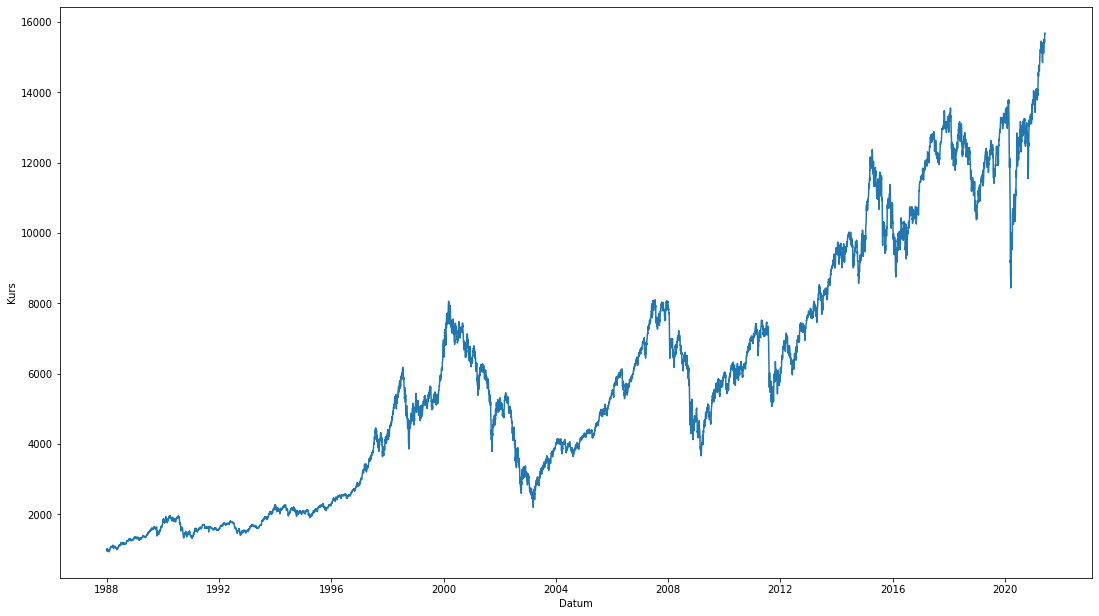

In [12]:
dax_data = database.query_index_values("DE0008469008")

dates = list([s.date for s in dax_data])
close_values = list([s.close for s in dax_data])

plt.plot(dates, close_values)
plt.xlabel('Datum')
plt.ylabel('Kurs')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Create a weekday statistic

In [13]:
weekday_statistic = st.create_weekday_statistic(dax_data)
[x.__dict__ for x in weekday_statistic]

[{'weekday': 0,
  'count': 1658,
  'days_positive': 893,
  'days_negative': 765,
  'total_positive': 51714.629755000016,
  'total_negative': -46715.70601200004,
  'days_ratio': 1.1673202614379086,
  'total_ratio': 1.1070073465595465},
 {'weekday': 1,
  'count': 1710,
  'days_positive': 903,
  'days_negative': 807,
  'total_positive': 50900.17597600003,
  'total_negative': -43226.46563000002,
  'days_ratio': 1.1189591078066914,
  'total_ratio': 1.1775234277001425},
 {'weekday': 2,
  'count': 1707,
  'days_positive': 903,
  'days_negative': 804,
  'total_positive': 47125.37262499999,
  'total_negative': -44886.42023200006,
  'days_ratio': 1.123134328358209,
  'total_ratio': 1.0498803954832592},
 {'weekday': 3,
  'count': 1690,
  'days_positive': 903,
  'days_negative': 787,
  'total_positive': 46849.01392799998,
  'total_negative': -48984.46221599995,
  'days_ratio': 1.1473951715374842,
  'total_ratio': 0.9564055990125281},
 {'weekday': 4,
  'count': 1678,
  'days_positive': 897,
  'days

# Plotting the weekday statistic for multiple time ranges

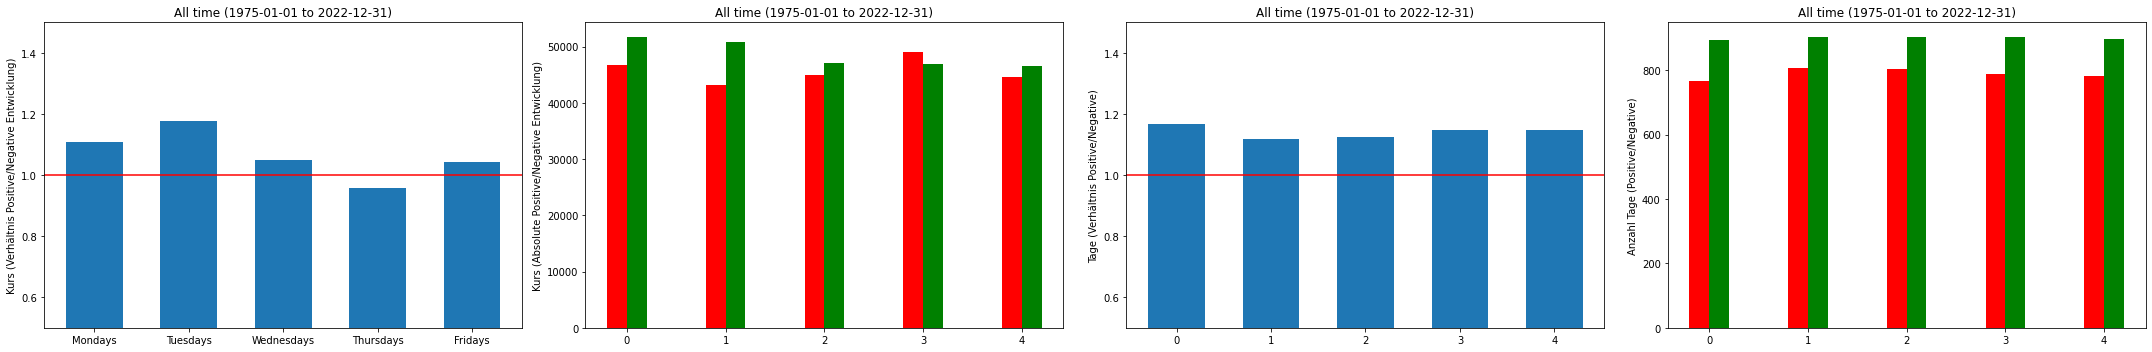

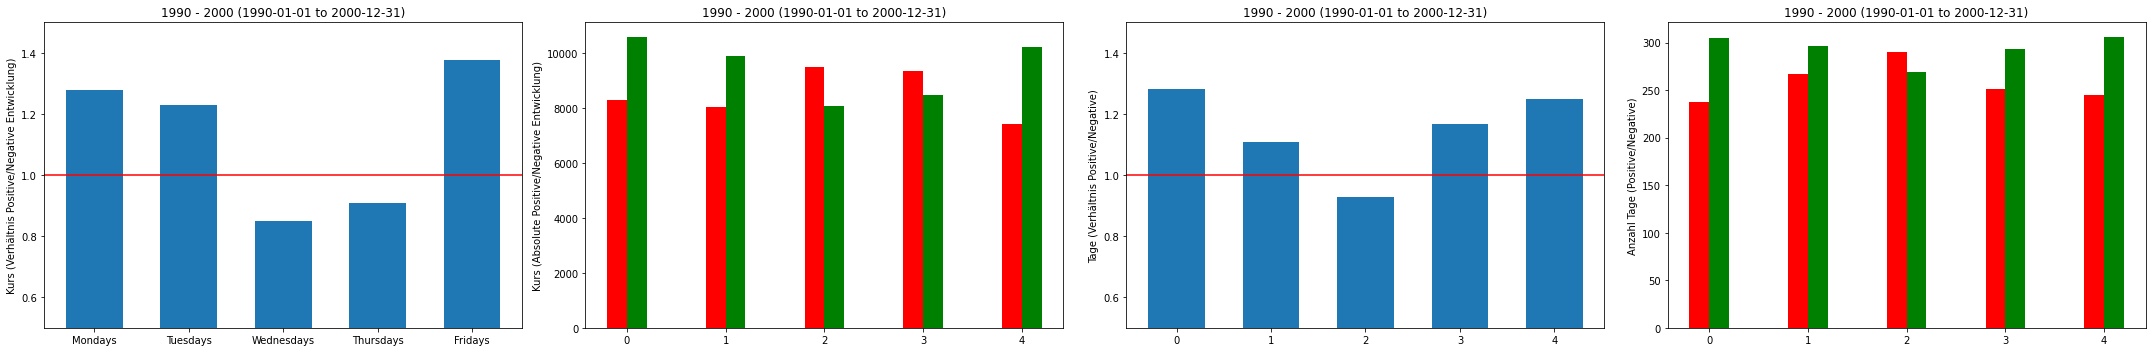

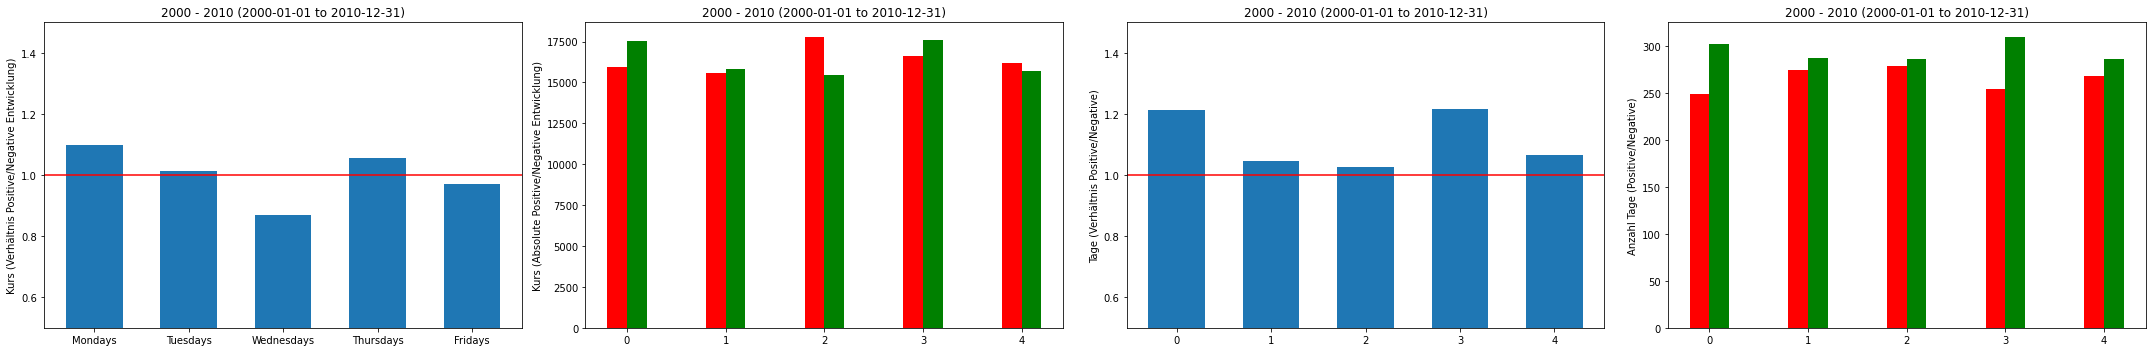

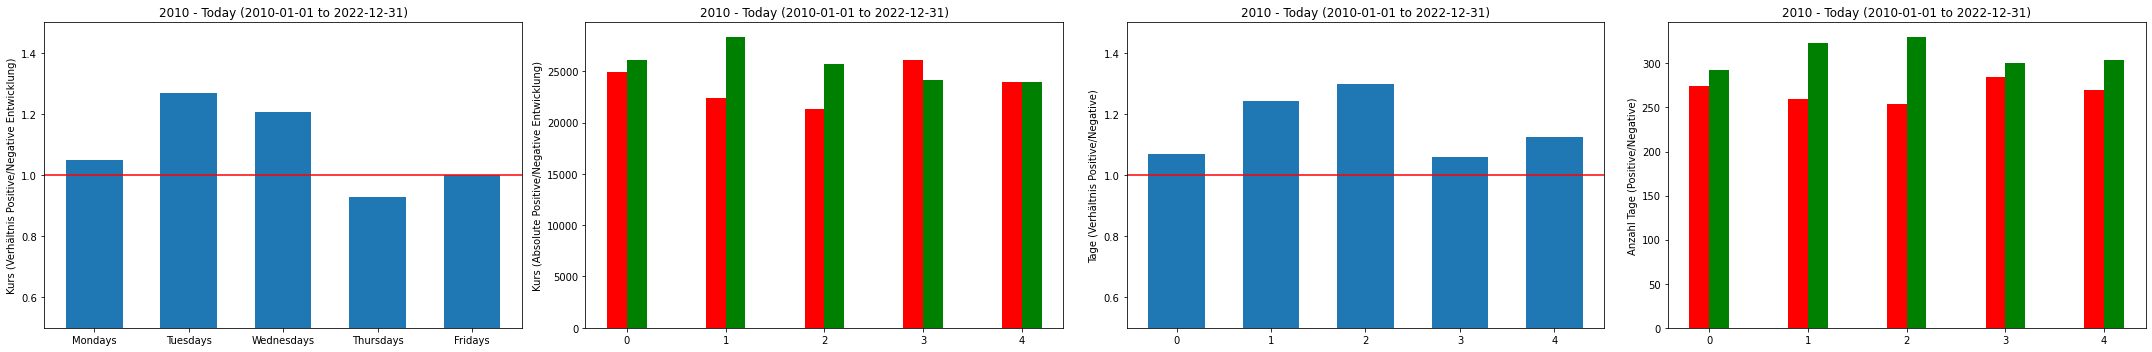

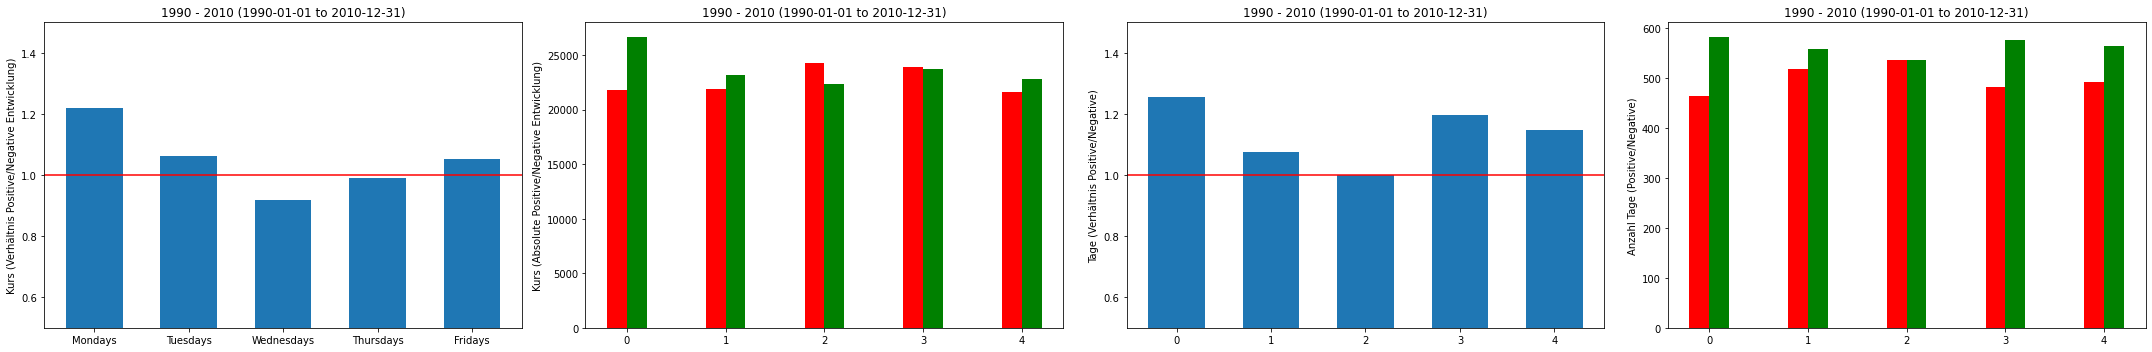

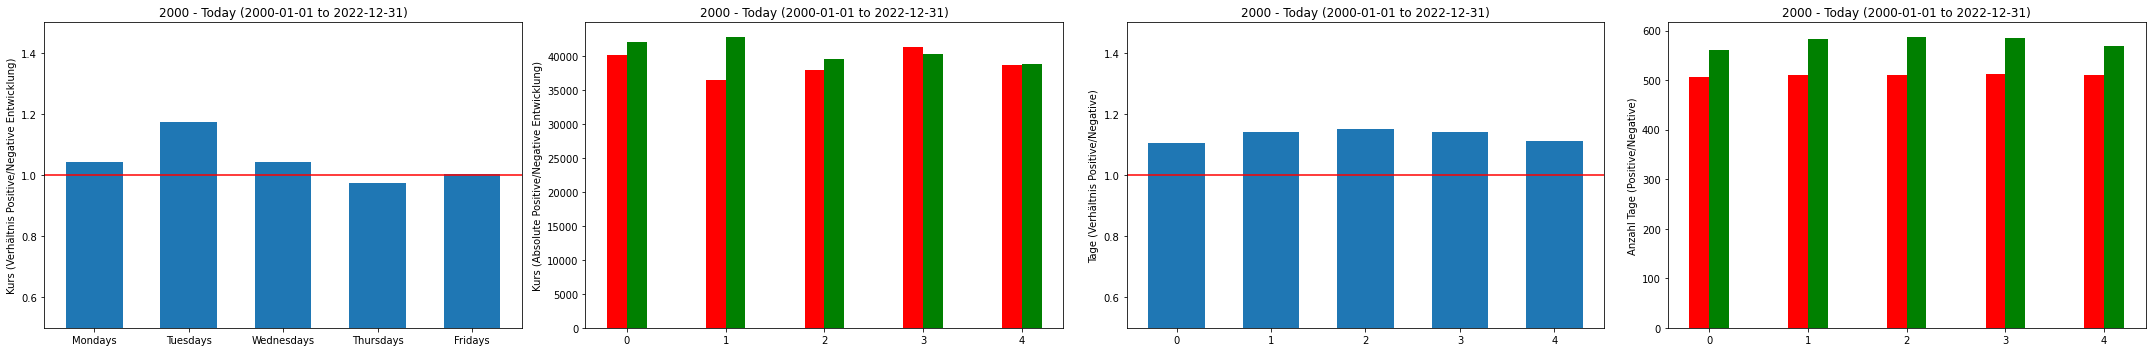

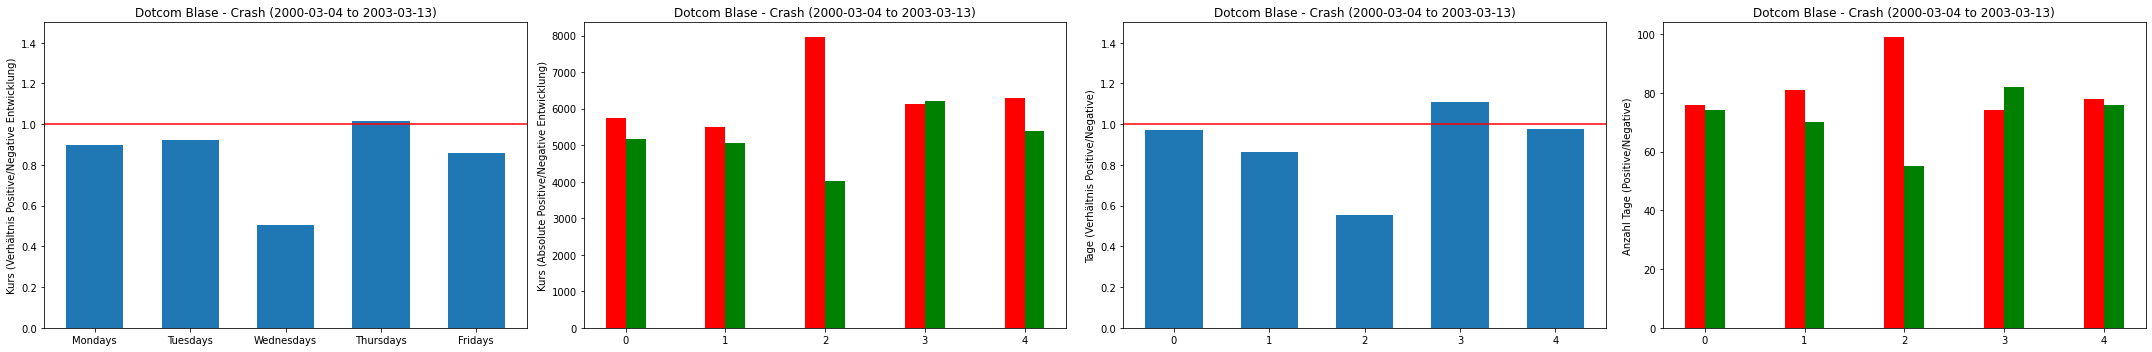

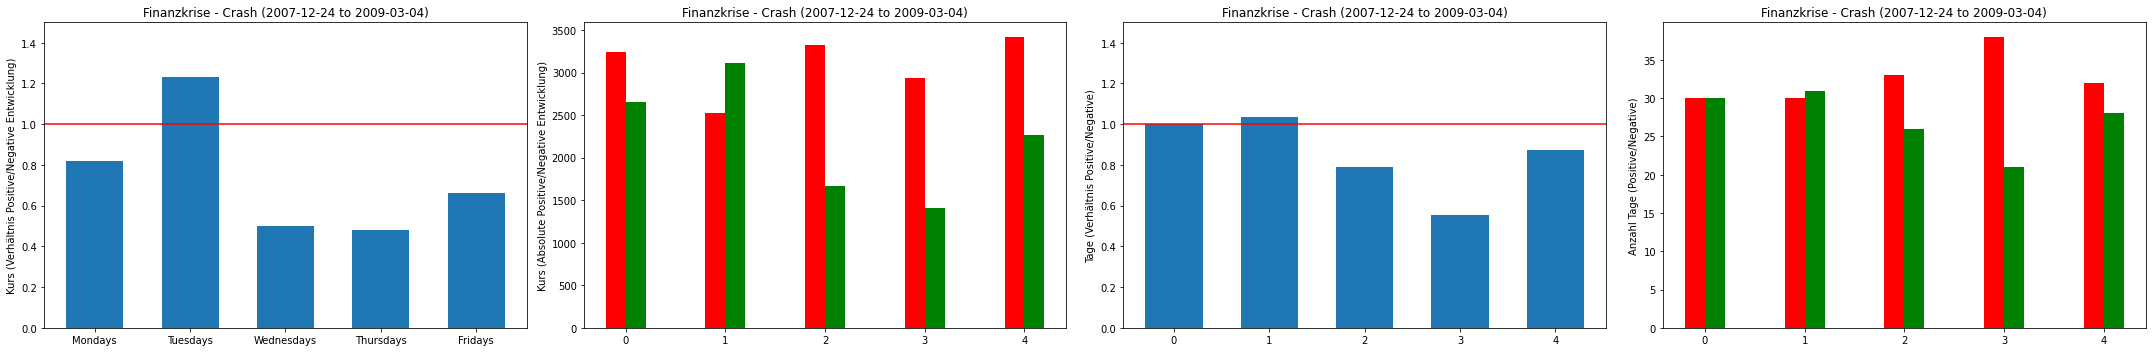

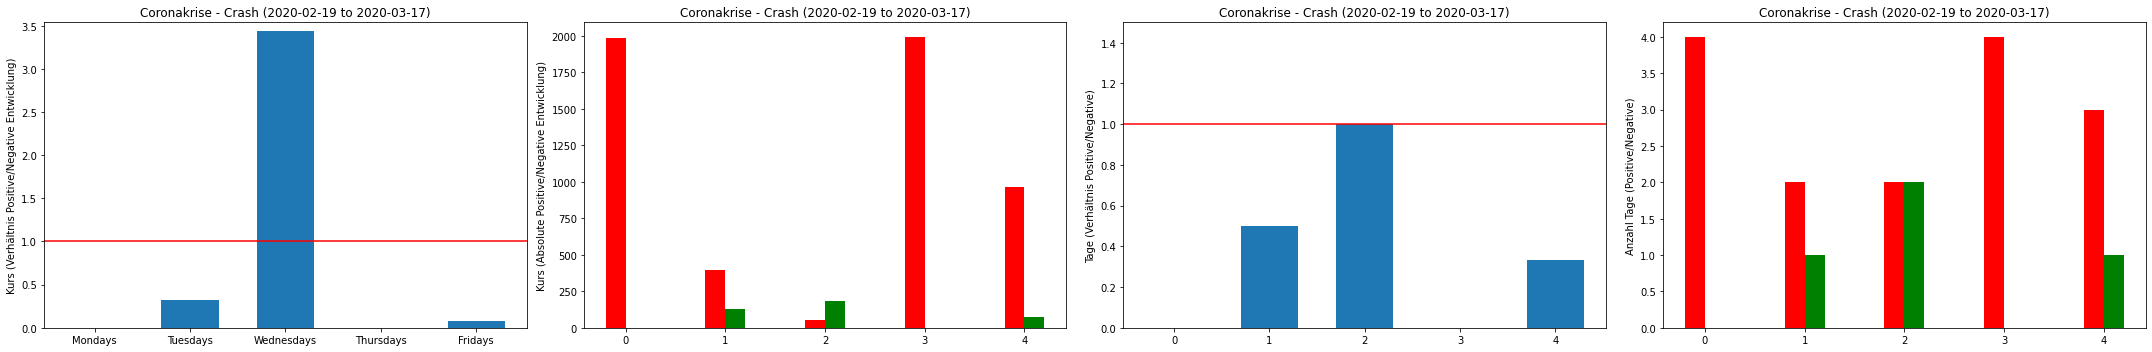

In [15]:
def query_data_and_plot_all(isin, time_range):
    data = database.query_index_values(isin, time_range.start, time_range.end)
    weekday_statistic = st.create_weekday_statistic(data)

    fig, ax = plt.subplots(ncols=4, figsize=(30, 5))
    
    query_data_and_plot_statistic_ratio(data, weekday_statistic, ax[0])
    query_data_and_plot_pos_neg(data, weekday_statistic, ax[1])
    query_data_and_plot_days_ratio(data, weekday_statistic, ax[2])
    query_data_and_plot_days_total(data, weekday_statistic, ax[3])
    
    plt.tight_layout()
    plt.show()

def query_data_and_plot_statistic_ratio(data, weekday_statistic, ax):
    plt_x = list([c.weekday_names[s.weekday] for s in weekday_statistic])
    plt_values = list([s.total_ratio for s in weekday_statistic])

    ymin = 0.5 if min(plt_values) >= 0.6 else 0
    ymax = 1.5 if max(plt_values) <= 1.4 else max(plt_values) + 0.1

    ax.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)
    ax.set_ylim(ymin, ymax)
    ax.axhline(y=1, color='r', linestyle='-')
    ax.set_ylabel("Kurs (Verhältnis Positive/Negative Entwicklung)")
    ax.set_title(t.name + ' (' + t.start + ' to ' + t.end + ')')

def query_data_and_plot_pos_neg(data, weekday_statistic, ax):
    plt_x1 = list([s.weekday + 0.1 for s in weekday_statistic])
    plt_x2 = list([s.weekday - 0.1 for s in weekday_statistic])
    plt_y1 = list([s.total_positive for s in weekday_statistic])
    plt_y2 = list([-s.total_negative for s in weekday_statistic])

    ax.bar(plt_x1, plt_y1, width=0.2, color='g', align='center')
    ax.bar(plt_x2, plt_y2, width=0.2, color='r', align='center')
    ax.set_ylabel("Kurs (Absolute Positive/Negative Entwicklung)")
    ax.set_title(t.name + ' (' + t.start + ' to ' + t.end + ')')

def query_data_and_plot_days_ratio(data, weekday_statistic, ax):
    plt_x = list([s.weekday for s in weekday_statistic])
    plt_values = list([s.days_ratio for s in weekday_statistic])

    ymin = 0.5 if min(plt_values) >= 0.6 else 0
    ymax = 1.5 if max(plt_values) <= 1.4 else max(plt_values) + 0.1

    ax.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)
    ax.set_ylim(ymin, ymax)
    ax.axhline(y=1, color='r', linestyle='-')
    ax.set_ylabel("Tage (Verhältnis Positive/Negative)")
    ax.set_title(t.name + ' (' + t.start + ' to ' + t.end + ')')

def query_data_and_plot_days_total(data, weekday_statistic, ax):
    plt_x1 = list([s.weekday + 0.1 for s in weekday_statistic])
    plt_x2 = list([s.weekday - 0.1 for s in weekday_statistic])
    plt_y1 = list([s.days_positive for s in weekday_statistic])
    plt_y2 = list([s.days_negative for s in weekday_statistic])

    ax.bar(plt_x1, plt_y1, width=0.2, color='g', align='center')
    ax.bar(plt_x2, plt_y2, width=0.2, color='r', align='center')
    ax.set_ylabel("Anzahl Tage (Positive/Negative)")
    ax.set_title(t.name + ' (' + t.start + ' to ' + t.end + ')')

time_ranges = [
    TimeRange("All time", "1975-01-01", "2022-12-31"), 
    TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
    TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
    TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
    TimeRange("1990 - 2010", "1990-01-01", "2010-12-31"), 
    TimeRange("2000 - Today", "2000-01-01", "2022-12-31"), 
#    TimeRange("Dotcom Blase - Crash", "2000-03-04", "2003-03-13"),
#    TimeRange("Finanzkrise - Crash", "2007-12-24", "2009-03-04"),
#    TimeRange("Coronakrise - Crash", "2020-02-19", "2020-03-17"),
]

for t in time_ranges:
    query_data_and_plot_all("DE0008469008", t)